In [1]:
import numpy as np
import torch
from pyro import distributions as dist
from pyro.poutine import trace, uncondition
from torch.distributions import constraints
import pyro.optim
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.infer import NUTS,MCMC
import matplotlib.pyplot as plt
import pdb
import sys
sys.path.append("../..")
from models_and_guides import *
from initializations import *

In [2]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [3]:
def piecewise_eval(knot_x, knot_y, x):
    # I haven't unit tested this:
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    #slopes = (y1-y0)/(x1-x0)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)
    
#def piecewise_regression(x, y, n_pieces=3):
#    knot_x = pyro.sample("knot_x",
#                         dist.Uniform(0, 100)
#                             .expand([n_pieces]).to_event(0))
#    knot_y = pyro.sample("knot_y",
#                         dist.Normal(0, 100)
#                             .expand([n_pieces]).to_event(0))
#    y_pred = piecewise_eval(knot_x, knot_y, x)
#    y_scale = pyro.sample("y_scale", dist.LogNormal(0, 1))
#    y = pyro.sample("obs", dist.Normal(y_pred, y_scale),
#                obs=y)
#    return y

def piecewise_regression(x, y, n_pieces=3):
    knot_x = pyro.sample("knot_x",
                         dist.Uniform(0, 1)
                             .expand([n_pieces]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         dist.Normal(0, 1)
                             .expand([n_pieces]).to_event(0))
    x_len = x.shape[0]
    y_pred = piecewise_eval(x_len*knot_x, x_len*knot_y, x)
    y_scale = pyro.sample("y_scale", dist.LogNormal(0, 1))
    y = pyro.sample("obs", dist.Normal(y_pred, y_scale),
                obs=y)
    return y

In [4]:
N = 100
x = torch.arange(N)
n_pieces = 5
dgp_trace = trace(uncondition(piecewise_regression)).get_trace(x,x,n_pieces)

In [5]:
dgp_vars = {name:dgp_trace.nodes[name]['value'] for name in dgp_trace.reparameterized_nodes}

In [6]:
y = dgp_vars['obs']

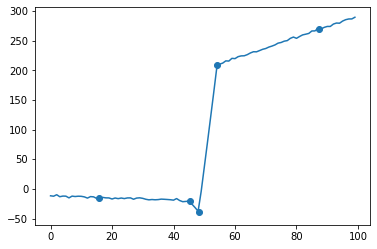

In [7]:
plt.plot(x,y)
plt.scatter(N*dgp_vars['knot_x'],N*dgp_vars['knot_y'])

In [8]:
from pyro.infer.autoguide.initialization import init_to_sample

In [9]:
guide = AutoDiagonalNormal(piecewise_regression,init_loc_fn=init_to_sample)

In [10]:
pyro.clear_param_store()

In [11]:
optim = pyro.optim.Adam({"lr": 0.06})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, guide, optim, loss=elbo)

In [ ]:
losses = []
guide(x,y,n_pieces)
param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
gradient_norms = defaultdict(list)
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

for i in range(10000):
    losses.append(svi.step(x,y,n_pieces))
    param_history = {k:torch.cat([param_history[k],v.unsqueeze(0).detach()],dim=0) for k,v in pyro.get_param_store().items()}

In [ ]:
plt.plot(list(gradient_norms.values())[0])
plt.yscale('log')

In [ ]:
plt.plot(losses)

In [ ]:
param_history

In [ ]:
param_history['AutoDiagonalNormal.loc'][-1]

In [ ]:
#pred = pyro.infer.predictive.Predictive(uncondition(piecewise_regression),guide=guide,num_samples=10)
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=guide,num_samples=100)

fit = pred(x,y,n_pieces)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

%matplotlib qt
plt.plot(x,y)
plt.scatter(N*dgp_vars['knot_x'],N*dgp_vars['knot_y'])
plt.errorbar(x,fit_obs_mean,yerr=fit_obs_std,alpha=.2)
plt.scatter(N*fit['knot_x'].detach().numpy(),N*fit['knot_y'].detach().numpy())
plt.axis('equal');
#plt.plot(x,slope_fit*x.numpy()+intercept_fit)
#plt.plot(x,fit_obs)

In [ ]:
dgp_vars

In [ ]:
fit